In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [2]:
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = ROOT / "data_processed"

train = pd.read_csv(DATA_PROCESSED / "train_pilot.csv")
valid = pd.read_csv(DATA_PROCESSED / "valid_pilot.csv")
baseline = pd.read_csv(DATA_PROCESSED / "baseline_predictions_pilot.csv")

train["invoice_date"] = pd.to_datetime(train["invoice_date"], errors="coerce")
valid["invoice_date"] = pd.to_datetime(valid["invoice_date"], errors="coerce")
baseline["invoice_date"] = pd.to_datetime(baseline["invoice_date"], errors="coerce")

print("Train:", train.shape, train["invoice_date"].min(), "->", train["invoice_date"].max())
print("Valid:", valid.shape, valid["invoice_date"].min(), "->", valid["invoice_date"].max())
print("Baseline:", baseline.shape)

Train: (13258, 14) 2018-01-02 00:00:00 -> 2021-12-12 00:00:00
Valid: (4254, 14) 2022-01-02 00:00:00 -> 2022-12-12 00:00:00
Baseline: (4254, 16)


In [3]:
TARGET = "invoice_count"

base_features = ["dow", "month", "is_weekend"]
weather_features = ["tavg", "tmin", "tmax", "prcp", "wspd", "snow", "is_rain", "is_freezing"]

feature_cols = []
for c in base_features + weather_features:
    if c in train.columns and c in valid.columns:
        feature_cols.append(c)

# include store_id if present (very helpful)
if "store_id" in train.columns and "store_id" in valid.columns:
    feature_cols.append("store_id")

print("Features used:", feature_cols)
print("Missing target in train:", train[TARGET].isna().sum())
print("Missing target in valid:", valid[TARGET].isna().sum())

Features used: ['dow', 'month', 'is_weekend', 'tmin', 'tmax', 'prcp', 'wspd', 'is_rain', 'is_freezing', 'store_id']
Missing target in train: 0
Missing target in valid: 0


In [4]:
X_train = train[feature_cols].copy()
y_train = train[TARGET].astype(float)

X_valid = valid[feature_cols].copy()
y_valid = valid[TARGET].astype(float)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_valid:", X_valid.shape, "y_valid:", y_valid.shape)

X_train: (13258, 10) y_train: (13258,)
X_valid: (4254, 10) y_valid: (4254,)


In [5]:
categorical_features = ["store_id"] if "store_id" in feature_cols else []
numeric_features = [c for c in feature_cols if c not in categorical_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("ridge", Ridge(alpha=1.0))
])

Numeric: ['dow', 'month', 'is_weekend', 'tmin', 'tmax', 'prcp', 'wspd', 'is_rain', 'is_freezing']
Categorical: ['store_id']


In [6]:
model.fit(X_train, y_train)
pred_weather = model.predict(X_valid)
print("Weather model is trained.")

Weather model is trained.


In [7]:
mae_weather = mean_absolute_error(y_valid, pred_weather)
mape_weather = np.mean(np.abs((y_valid - pred_weather) / np.clip(y_valid, 1, None))) * 100

print("Weather Model (Ridge)")
print("MAE :", round(mae_weather, 3))
print("MAPE:", round(mape_weather, 3), "%")

Weather Model (Ridge)
MAE : 10.135
MAPE: 23.884 %


In [8]:
from sklearn.metrics import mean_absolute_error

key_cols = ["store_id", "invoice_date"]

cmp = valid[key_cols + ["invoice_count"]].merge(
    baseline[key_cols + ["pred"]],
    on=key_cols,
    how="left"
)

mae_base = mean_absolute_error(cmp["invoice_count"], cmp["pred"])
mape_base = (
    np.mean(
        np.abs(cmp["invoice_count"] - cmp["pred"]) /
        np.clip(cmp["invoice_count"], 1, None)
    ) * 100
)

print("Baseline (store + day-of-week)")
print("MAE :", round(mae_base, 3))
print("MAPE:", round(mape_base, 3), "%")

print("\nImprovement (weather - baseline)")
print("Δ MAE :", round(mae_weather - mae_base, 3))
print("Δ MAPE:", round(mape_weather - mape_base, 3), "%")

Baseline (store + day-of-week)
MAE : 9.245
MAPE: 20.716 %

Improvement (weather - baseline)
Δ MAE : 0.889
Δ MAPE: 3.169 %


In [9]:
#Time-aware features (per store)
df_all = pd.concat([train, valid], ignore_index=True).sort_values(["store_id", "invoice_date"])

# Lag features- yesterday, last week, 2 weeks
for lag in [1, 7, 14]:
    df_all[f"lag_{lag}"] = df_all.groupby("store_id")["invoice_count"].shift(lag)

# Rolling averages (using past values only)
df_all["roll_mean_7"]  = df_all.groupby("store_id")["invoice_count"].shift(1).rolling(7).mean().reset_index(level=0, drop=True)
df_all["roll_mean_14"] = df_all.groupby("store_id")["invoice_count"].shift(1).rolling(14).mean().reset_index(level=0, drop=True)

#rolling std (captures volatility)
df_all["roll_std_7"] = df_all.groupby("store_id")["invoice_count"].shift(1).rolling(7).std().reset_index(level=0, drop=True)

# Split back into train/valid by date (same cutoff logic you used)
cutoff = pd.Timestamp("2022-01-01")
train2 = df_all[df_all["invoice_date"] < cutoff].copy()
valid2 = df_all[df_all["invoice_date"] >= cutoff].copy()

print("train2:", train2.shape, train2["invoice_date"].min(), "->", train2["invoice_date"].max())
print("valid2:", valid2.shape, valid2["invoice_date"].min(), "->", valid2["invoice_date"].max())
print("New feature NaNs in train2:\n", train2[["lag_1","lag_7","lag_14","roll_mean_7","roll_mean_14","roll_std_7"]].isna().mean().round(3))

train2: (13258, 20) 2018-01-02 00:00:00 -> 2021-12-12 00:00:00
valid2: (4254, 20) 2022-01-02 00:00:00 -> 2022-12-12 00:00:00
New feature NaNs in train2:
 lag_1           0.001
lag_7           0.004
lag_14          0.008
roll_mean_7     0.004
roll_mean_14    0.007
roll_std_7      0.004
dtype: float64


In [10]:
TARGET = "invoice_count"

# Existing base and weather
base_features = ["dow", "month", "is_weekend"]
weather_features = ["tavg", "tmin", "tmax", "prcp", "wspd", "snow", "is_rain", "is_freezing"]

# New time-aware features
time_features = ["lag_1", "lag_7", "lag_14", "roll_mean_7", "roll_mean_14", "roll_std_7"]

feature_cols2 = []
for c in base_features + weather_features + time_features:
    if c in train2.columns and c in valid2.columns:
        feature_cols2.append(c)

# Keep store_id for store-specific patterns
feature_cols2.append("store_id")

print("Upgraded features:", feature_cols2)

Upgraded features: ['dow', 'month', 'is_weekend', 'tmin', 'tmax', 'prcp', 'wspd', 'is_rain', 'is_freezing', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_7', 'roll_mean_14', 'roll_std_7', 'store_id']


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

X_train2 = train2[feature_cols2].copy()
y_train2 = train2[TARGET].astype(float)

X_valid2 = valid2[feature_cols2].copy()
y_valid2 = valid2[TARGET].astype(float)

categorical_features = ["store_id"]
numeric_features = [c for c in feature_cols2 if c not in categorical_features]

preprocess2 = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ],
    remainder="drop"
)

model2 = Pipeline(steps=[
    ("preprocess", preprocess2),
    ("ridge", Ridge(alpha=1.0))
])

model2.fit(X_train2, y_train2)
pred2 = model2.predict(X_valid2)

mae2 = mean_absolute_error(y_valid2, pred2)
mape2 = np.mean(np.abs((y_valid2 - pred2) / np.clip(y_valid2, 1, None))) * 100

print("Upgraded the Time and Weather Model (Ridge)")
print("MAE :", round(mae2, 3))
print("MAPE:", round(mape2, 3), "%")

Upgraded the Time and Weather Model (Ridge)
MAE : 4.828
MAPE: 12.419 %


In [13]:
# Baseline comparison on the SAME valid2 rows (important)
cmp2 = valid2[["store_id", "invoice_date", TARGET]].merge(
    baseline[["store_id", "invoice_date", "pred"]],
    on=["store_id", "invoice_date"],
    how="left"
)
mae_base2 = mean_absolute_error(cmp2[TARGET], cmp2["pred"])
mape_base2 = np.mean(np.abs((cmp2[TARGET] - cmp2["pred"]) / np.clip(cmp2[TARGET], 1, None))) * 100
print("Baseline (store + day-of-week)")
print("MAE :", round(mae_base2, 3))
print("MAPE:", round(mape_base2, 3), "%")
print("\nImprovement (upgraded - baseline)")
print("Δ MAE :", round(mae2 - mae_base2, 3))
print("Δ MAPE:", round(mape2 - mape_base2, 3), "%")

Baseline (store + day-of-week)
MAE : 9.245
MAPE: 20.716 %

Improvement (upgraded - baseline)
Δ MAE : -4.417
Δ MAPE: -8.296 %


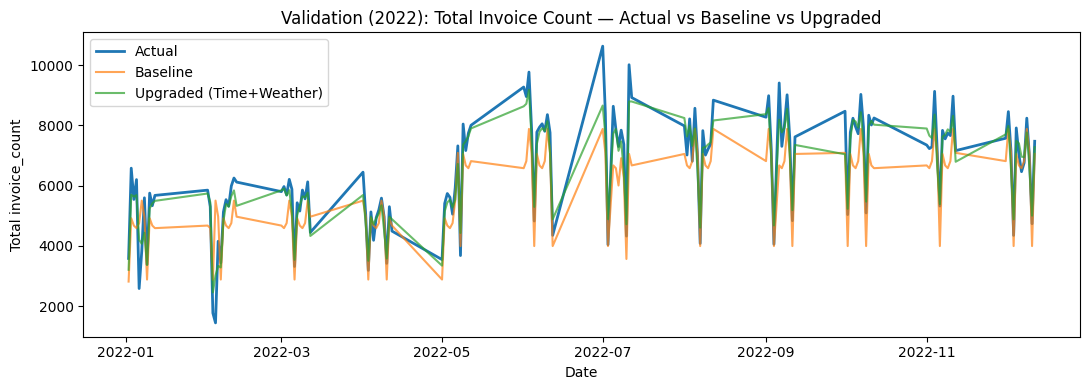

In [14]:
#Daily totals sanity check (Actual vs Baseline vs Upgraded)
key_cols = ["store_id", "invoice_date"]

plot_df = valid2[key_cols + [TARGET]].copy()
plot_df["upgraded_pred"] = pred2  # this is your upgraded model prediction

plot_df = plot_df.merge(
    baseline[key_cols + ["pred"]],
    on=key_cols,
    how="left"
).rename(columns={"pred": "baseline_pred"})

daily_actual = plot_df.groupby("invoice_date", as_index=False)[TARGET].sum()
daily_baseline = plot_df.groupby("invoice_date", as_index=False)["baseline_pred"].sum()
daily_upgraded = plot_df.groupby("invoice_date", as_index=False)["upgraded_pred"].sum()

import matplotlib.pyplot as plt

plt.figure(figsize=(11, 4))
plt.plot(daily_actual["invoice_date"], daily_actual[TARGET], label="Actual", linewidth=2)
plt.plot(daily_baseline["invoice_date"], daily_baseline["baseline_pred"], label="Baseline", alpha=0.7)
plt.plot(daily_upgraded["invoice_date"], daily_upgraded["upgraded_pred"], label="Upgraded (Time+Weather)", alpha=0.7)
plt.title("Validation (2022): Total Invoice Count — Actual vs Baseline vs Upgraded")
plt.xlabel("Date")
plt.ylabel("Total invoice_count")
plt.legend()
plt.tight_layout()
plt.show()

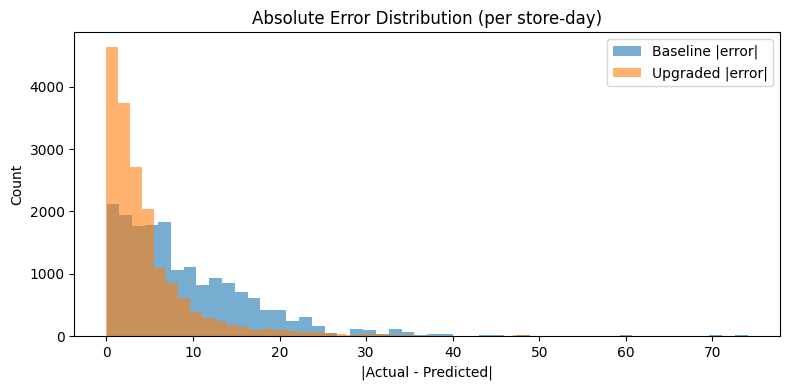

In [15]:
#Error distribution (Baseline vs Upgraded)
plot_df["abs_err_baseline"] = (plot_df[TARGET] - plot_df["baseline_pred"]).abs()
plot_df["abs_err_upgraded"] = (plot_df[TARGET] - plot_df["upgraded_pred"]).abs()

plt.figure(figsize=(8, 4))
plt.hist(plot_df["abs_err_baseline"].dropna(), bins=50, alpha=0.6, label="Baseline |error|")
plt.hist(plot_df["abs_err_upgraded"].dropna(), bins=50, alpha=0.6, label="Upgraded |error|")
plt.title("Absolute Error Distribution (per store-day)")
plt.xlabel("|Actual - Predicted|")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

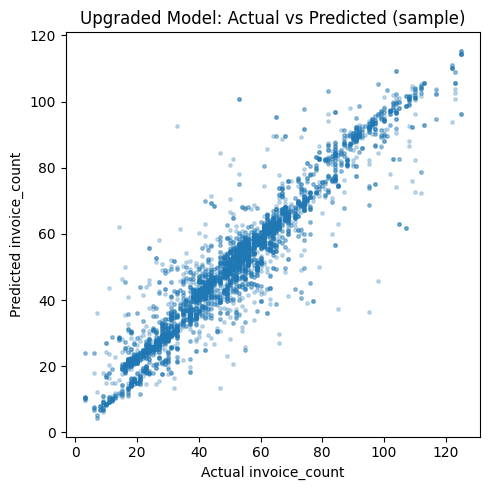

In [16]:
#Actual vs Predicted scatter (Upgraded)
sample = plot_df.dropna(subset=["upgraded_pred"]).sample(min(5000, len(plot_df)), random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(sample[TARGET], sample["upgraded_pred"], s=6, alpha=0.25)
plt.title("Upgraded Model: Actual vs Predicted (sample)")
plt.xlabel("Actual invoice_count")
plt.ylabel("Predicted invoice_count")
plt.tight_layout()
plt.show()

In [17]:
import joblib

out_pred = DATA_PROCESSED / "weather_time_model_predictions_pilot.csv"
out_model = DATA_PROCESSED / "weather_time_model_ridge_pilot.pkl"

save_df = valid2[["store_id", "invoice_date", TARGET]].copy()
save_df["pred_time_weather"] = pred2
save_df.to_csv(out_pred, index=False)

joblib.dump(model2, out_model)

print("Saved:", out_pred)
print("Saved:", out_model)

Saved: c:\Users\harsh\github\GenAI-Weather-Based-Store-Analytics\data_processed\weather_time_model_predictions_pilot.csv
Saved: c:\Users\harsh\github\GenAI-Weather-Based-Store-Analytics\data_processed\weather_time_model_ridge_pilot.pkl
